In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import tensorflow as tf
import numpy as np
import gym
from tqdm import tqdm, trange
import os,sys
sys.path.append(os.getcwd())

Populating the interactive namespace from numpy and matplotlib


In [2]:
from muzero.model import MuModel

In [3]:
env = gym.make("CartPole-v0")
#env = gym.make("MountainCar-v0")
#env = gym.make("LunarLander-v2")
#env = gym.make("Acrobot-v1")
m = MuModel(env.observation_space.shape, env.action_space.n)
env.reset(), env.observation_space.shape, env.action_space.n

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


(array([ 0.99737701,  0.07238165,  0.99727917, -0.07371748, -0.01669781,
        -0.03544146]), (6,), 3)

In [4]:
from muzero.game import Game, ReplayBuffer
replay_buffer = ReplayBuffer(100, 128)

In [5]:
from muzero.mcts import get_mcts_policy, ucb_score
# init the game
game = Game(env)
policy, root = get_mcts_policy(m, game.observation, 100)
print(root.visit_count, root.children[0].visit_count, root.children[1].visit_count)
print(root.children[0].prior, root.children[1].prior)
print(ucb_score(root, root.children[0]), ucb_score(root, root.children[1]))

100 42 29
0.4570773380946904 0.28351987196925854
-0.3040223647101356 -0.29961636141086256


In [6]:
def print_tree(x, hist=[]):
  print(x.value(), x, hist)
  for i,c in x.children.items():
    print_tree(c, hist+[i])
print_tree(root)

-0.4238723174847783 <muzero.mcts.Node object at 0x15d2b1c50> []
-0.19306281511417725 <muzero.mcts.Node object at 0x1112a5c10> [0]
-0.14156770581548864 <muzero.mcts.Node object at 0x15d2a5610> [0, 0]
-0.03702176436781884 <muzero.mcts.Node object at 0x15d2ad690> [0, 0, 0]
0 <muzero.mcts.Node object at 0x15d298410> [0, 0, 0, 0]
-0.17726436257362366 <muzero.mcts.Node object at 0x15d2984d0> [0, 0, 0, 1]
0 <muzero.mcts.Node object at 0x15d51d690> [0, 0, 0, 1, 0]
0 <muzero.mcts.Node object at 0x15d51d5d0> [0, 0, 0, 1, 1]
0 <muzero.mcts.Node object at 0x15d51d4d0> [0, 0, 0, 1, 2]
0.1040414422750473 <muzero.mcts.Node object at 0x15d298a10> [0, 0, 0, 2]
0 <muzero.mcts.Node object at 0x15d298510> [0, 0, 0, 2, 0]
0 <muzero.mcts.Node object at 0x15d2becd0> [0, 0, 0, 2, 1]
0 <muzero.mcts.Node object at 0x15d2beb90> [0, 0, 0, 2, 2]
-0.13253828411300977 <muzero.mcts.Node object at 0x15d2add10> [0, 0, 1]
0.16783522069454193 <muzero.mcts.Node object at 0x15d508e50> [0, 0, 1, 0]
0 <muzero.mcts.Node objec

In [7]:
def play_game():
  import random
  game = Game(env)
  while not game.terminal():
    #policy, _ = get_mcts_policy(m, game.observation)
    policy = search(m, game.observation)
    game.act_with_policy(policy)
  return game

In [10]:
from muzero.model import reformat_batch
for j in range(50):
  game = play_game()
  if len(game.history) < 20:
    print(game.history)
  replay_buffer.save_game(game)
  for i in range(10):
    m.train_on_batch(replay_buffer.sample_batch(5))
  print(len(game.history), m.losses[-1][0])
  #if len(game.history) == 200 and j > 3:
  #  break

423 2106.1628
500 1419.5226
500 800.7675
500 580.81964
500 389.50262
500 304.88544
500 262.16415
500 232.06586
500 224.17107
500 173.40028
500 148.12866
500 115.03043
500 86.51801
500 94.62875
500 68.942566
500 45.49961
500 27.122948
500 44.19971
500 45.23701
500 32.32317
500 43.74053
500 41.283585
500 47.941807
500 48.544388
500 22.279009
500 43.943077
500 33.448547
500 21.19056
500 29.377562
500 43.99718
500 47.706135
500 17.177397
500 31.32163
500 28.532461


KeyboardInterrupt: 

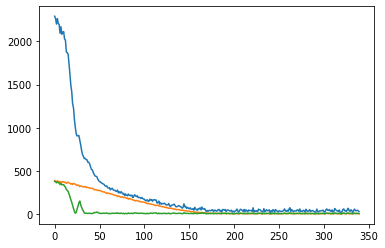

In [11]:
plot([x[0] for x in m.losses])
plot([x[1] for x in m.losses])
plot([x[-3] for x in m.losses])

In [15]:
# can act?
state = env.reset()
for sn in range(2000):
  p_0 = search(m, state, debug=False)
  _, v_0 = m.ft(m.ht(state))
  #p_0, _ = get_mcts_policy(m, state, 50)
  a_1 = np.random.choice(list(range(len(p_0))), p=p_0)
  
  #a_1 = np.argmax(p_0)
  #print(p_0, v_0, a_1)
  env.render()
  state,r,done,_ = env.step(a_1)
  print(a_1, v_0, r, p_0)
  if done:
    print("DONE", sn)
    break

2 -19.901783 -1.0 [2.77529000e-05 1.95200377e-03 9.98020243e-01]
2 -19.882317 -1.0 [3.00354868e-05 2.13086488e-03 9.97839100e-01]
2 -19.801441 -1.0 [3.13504275e-05 2.26593444e-03 9.97702715e-01]
2 -19.644136 -1.0 [3.07884234e-05 2.29852927e-03 9.97670682e-01]
2 -19.42418 -1.0 [2.82699488e-05 2.20454563e-03 9.97767184e-01]
2 -19.19971 -1.0 [2.48261846e-05 2.02280038e-03 9.97952373e-01]
2 -19.04795 -1.0 [2.18249674e-05 1.82391335e-03 9.98154262e-01]
2 -19.022234 -1.0 [1.98603307e-05 1.65607156e-03 9.98324068e-01]
2 -19.126032 -1.0 [1.91916785e-05 1.55329262e-03 9.98427516e-01]
2 -19.315937 -1.0 [1.97636494e-05 1.52901155e-03 9.98451225e-01]
2 -19.52584 -1.0 [2.13290600e-05 1.57999426e-03 9.98398677e-01]
2 -19.699675 -1.0 [2.34615497e-05 1.69384668e-03 9.98282692e-01]
2 -19.809319 -1.0 [2.57333904e-05 1.85263773e-03 9.98121629e-01]
2 -19.849596 -1.0 [2.76942504e-05 2.02111261e-03 9.97951193e-01]
2 -19.82582 -1.0 [2.88826018e-05 2.15137350e-03 9.97819744e-01]
2 -19.75111 -1.0 [2.89594736e-

2 -19.736961 -1.0 [2.32684799e-05 1.69241326e-03 9.98284318e-01]
2 -19.830389 -1.0 [2.49423563e-05 1.76699237e-03 9.98208065e-01]
2 -19.873455 -1.0 [2.70630721e-05 1.89740997e-03 9.98075527e-01]
2 -19.866804 -1.0 [2.92418862e-05 2.05639450e-03 9.97914364e-01]
2 -19.801733 -1.0 [3.07130664e-05 2.19485034e-03 9.97774437e-01]
2 -19.66306 -1.0 [3.05893692e-05 2.25459212e-03 9.97714819e-01]
2 -19.456259 -1.0 [2.85635129e-05 2.20324337e-03 9.97768193e-01]
2 -19.22824 -1.0 [2.53585443e-05 2.05604102e-03 9.97918600e-01]
2 -19.053587 -1.0 [2.23177459e-05 1.87425253e-03 9.98103430e-01]
2 -18.99615 -1.0 [2.01165566e-05 1.70304808e-03 9.98276835e-01]
2 -19.076557 -1.0 [1.91264551e-05 1.58203397e-03 9.98398840e-01]
2 -19.264069 -1.0 [1.93506749e-05 1.53010581e-03 9.98450544e-01]
2 -19.492 -1.0 [2.07072495e-05 1.55590032e-03 9.98423392e-01]
2 -19.692038 -1.0 [2.27387117e-05 1.64783984e-03 9.98329421e-01]
2 -19.824373 -1.0 [2.50866222e-05 1.79476499e-03 9.98180148e-01]
2 -19.881979 -1.0 [2.73470721e-

2 -19.78266 -1.0 [2.46868102e-05 1.76118886e-03 9.98214124e-01]
2 -19.833813 -1.0 [2.64316570e-05 1.85319097e-03 9.98120377e-01]
2 -19.839132 -1.0 [2.83426827e-05 1.98252147e-03 9.97989136e-01]
2 -19.789373 -1.0 [2.98107296e-05 2.11060132e-03 9.97859588e-01]
2 -19.671768 -1.0 [3.00427559e-05 2.18944743e-03 9.97780510e-01]
2 -19.48728 -1.0 [2.85820369e-05 2.17776143e-03 9.97793657e-01]
2 -19.270853 -1.0 [2.58222915e-05 2.07308690e-03 9.97901091e-01]
2 -19.08806 -1.0 [2.29277168e-05 1.91928025e-03 9.98057792e-01]
2 -19.005756 -1.0 [2.06107447e-05 1.75627730e-03 9.98223112e-01]
2 -19.058397 -1.0 [1.93545549e-05 1.62464853e-03 9.98355997e-01]
2 -19.23043 -1.0 [1.92474312e-05 1.54966201e-03 9.98431091e-01]
2 -19.46173 -1.0 [2.03291892e-05 1.55024005e-03 9.98429431e-01]
2 -19.677418 -1.0 [2.21847564e-05 1.61822958e-03 9.98359586e-01]
2 -19.826464 -1.0 [2.44682643e-05 1.74727061e-03 9.98228261e-01]
2 -19.897324 -1.0 [2.68561353e-05 1.92075578e-03 9.98052388e-01]
2 -19.900326 -1.0 [2.89479985e

2 -19.589397 -1.0 [2.48887160e-05 1.83002398e-03 9.98145087e-01]
2 -19.615662 -1.0 [2.59340427e-05 1.94303464e-03 9.98031031e-01]
2 -19.608078 -1.0 [2.63260879e-05 2.01952792e-03 9.97954146e-01]
2 -19.577507 -1.0 [2.59789610e-05 2.03412804e-03 9.97939893e-01]
2 -19.547686 -1.0 [2.51461599e-05 1.98628737e-03 9.97988566e-01]
2 -19.545334 -1.0 [2.42732710e-05 1.90351566e-03 9.98072211e-01]
2 -19.583628 -1.0 [2.37510245e-05 1.82064539e-03 9.98155604e-01]
2 -19.6531 -1.0 [2.38320462e-05 1.77082395e-03 9.98205344e-01]
2 -19.728045 -1.0 [2.45590781e-05 1.76942228e-03 9.98206019e-01]
2 -19.78218 -1.0 [2.58373125e-05 1.82017975e-03 9.98153983e-01]
2 -19.798117 -1.0 [2.74079022e-05 1.91454536e-03 9.98058047e-01]
2 -19.76388 -1.0 [2.87543024e-05 2.02480257e-03 9.97946443e-01]
2 -19.669243 -1.0 [2.92219791e-05 2.11001828e-03 9.97860760e-01]
2 -19.51365 -1.0 [2.83254719e-05 2.13208523e-03 9.97839589e-01]
2 -19.321457 -1.0 [2.61642931e-05 2.07341624e-03 9.97900419e-01]
2 -19.145409 -1.0 [2.35744412e

In [9]:
def to_one_hot(x,n):
  ret = np.zeros([n])
  ret[x] = 1.0
  return ret

# enumerate the whole action space
K = 5
import itertools
aopts = list(itertools.product(list(range(env.action_space.n)), repeat=K))
aoptss = np.array([[to_one_hot(x, env.action_space.n) for x in aa] for aa in aopts])
aoptss = aoptss.swapaxes(0,1)
aoptss = [aoptss[x] for x in range(K)]

# TODO: this is naive search, replace with MCTS
def search(m, o_0, debug=False):
  # concatenate the current state with every possible action
  o_0s = np.repeat(np.array(o_0)[None], len(aopts), axis=0)
  ret = m.mu.predict([o_0s]+aoptss)
  v_s = ret[-3]
  
  minimum = min(v_s)
  maximum = max(v_s)
  v_s = (v_s - minimum) / (maximum - minimum)
  
  # group the value with the action rollout that caused it
  v = [(v_s[i][0], aopts[i]) for i in range(len(v_s))]
  if debug:
    print(sorted(v, reverse=True))
  
  av = [0] * env.action_space.n
  for vk, ak in v:
    av[ak[0]] += vk

  av = np.array(av).astype(np.float64)
  
  #print(av)
  
  policy = np.exp(av)/sum(np.exp(av))
  return policy